In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.share import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on
re,Support for regular expressions (RE)
time,This module provides various functions to manipulate time values
inspect,Get useful information from live Python objects


In [18]:
# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 80)

TESTSETNAME = 'allset_unlabelled_annotation2.hdf'

In [19]:
# defining function to plot evaluations metric per feature and hyperparameter
def evalinfo(sem_df, score, sem_df_hyperparams = None):
    printhtml('<h3>%s</h3>' % score)
    
    if sem_df_hyperparams is None:
        sem_df_hyperparams = sem_df

    n_estimators = np.unique(sem_df_hyperparams.n_estimators.values)
    max_samples = np.unique(sem_df_hyperparams.max_samples.values)
    
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(
        sem_df_hyperparams, score, n_estimators=n_estimators, max_samples=max_samples
    )

    decimals = 4
    printhtml('<h4>Min %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmin.round(4))
    printhtml('<h4>Median %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmedian.round(4))
    printhtml('<h4>Max %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmax.round(4))

    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(5, 6, height_ratios=[.3, .05, .3, .05, .3])
    gs.update(wspace=0.0, hspace=0.9)

    # ax_feats_title = fig.add_subplot(gs[0, :])
    # ax_feats_title.set_title('Evaluation metrics vs Features')
    ax_feats = [fig.add_subplot(gs[0, :])]
    plot_feats_vs_evalmetrics(sem_df, [score], show=ax_feats)

    scorelabel = score.replace('_', ' ')

    ax_hp1 = [fig.add_subplot(gs[2, 0:2]), fig.add_subplot(gs[2, 2:4]), fig.add_subplot(gs[2, 4:6])]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=scorelabel, show=ax_hp1)

    ax_hp2 = [fig.add_subplot(gs[4, _]) for _ in range(6)]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=scorelabel, show=ax_hp2)

In [20]:
printhtml('<h3>Opening model evaluations computed on testset "%s"</h3>' % TESTSETNAME)

sem_df = read_summary_eval_df()  # "sem_df" stands for "summary evaluation metrics" (dataframe)
sem_df = sem_df[sem_df.relative_filepath.str.endswith(os.sep + TESTSETNAME)]
display(sem_df)

Opening model evaluations computed on testset "allset_unlabelled_annotation2.hdf"

,clf,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_roc_curve,best_th_pr_curve,behaviour,contamination,relative_filepath,tr_set
2538,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",100,1024,42,0.938151,0.926122,0.658329,0.639560,0.678275,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=42/allset_unlabelled_annotation2.hdf",allset_train.hdf
2539,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",200,1024,11,0.937190,0.926656,0.663101,0.662334,0.688424,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=11/allset_unlabelled_annotation2.hdf",allset_train.hdf
2540,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",50,1024,11,0.936968,0.926613,0.672072,0.672145,0.706885,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=11/allset_unlabelled_annotation2.hdf",allset_train.hdf
2541,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",100,1024,11,0.935997,0.925462,0.664150,0.656965,0.684540,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_unlabelled_annotation2.hdf",allset_train.hdf
2542,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",50,1024,25,0.928054,0.912020,0.680892,0.661674,0.673252,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/allset_unlabelled_annotation2.hdf",allset_train.hdf
2543,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",200,1024,42,0.938487,0.925880,0.666293,0.659681,0.684257,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=42/allset_unlabelled_annotation2.hdf",allset_train.hdf
2544,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",200,1024,25,0.933366,0.921982,0.669765,0.666830,0.686046,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=25/allset_unlabelled_annotation2.hdf",allset_train.hdf
2545,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",100,1024,25,0.928442,0.915777,0.673610,0.667481,0.683581,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=25/allset_unlabelled_annotation2.hdf",allset_train.hdf
2546,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",50,1024,42,0.935668,0.926260,0.664041,0.649186,0.689822,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=42/allset_unlabelled_annotation2.hdf",allset_train.hdf
2547,IsolationForest,"psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec",100,16384,25,0.933161,0.914521,0.595034,0.619288,0.649514,new,auto,"clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=25/allset_unlabelled_annotation2.hdf",allset_train.hdf


In [21]:
mean = 'median'
for metric, _eval_df in rank_eval(sem_df,
                                  # evalmetrics=['roc_auc_score', 'average_precision_score', 'f1_max'],
                                  evalmetrics=['average_precision_score', 'roc_auc_score'],
                                  columns=['clf', 'feats', 'n_estimators', 'max_samples'],
                                  mean=mean).items():
    printhtml("<h3>Ranking models according to %s (%s on 'random_state')</h3>" % (metric, mean))
    display(_eval_df)

Ranking models according to average_precision_score (median on 'random_state')

,clf,feats,n_estimators,max_samples,average_precision_score
260,IsolationForest,"psd@2sec,psd@5sec",100,2048,0.940823
254,IsolationForest,"psd@2sec,psd@5sec",50,2048,0.940502
266,IsolationForest,"psd@2sec,psd@5sec",200,2048,0.940499
265,IsolationForest,"psd@2sec,psd@5sec",200,1024,0.939954
267,IsolationForest,"psd@2sec,psd@5sec",200,4096,0.939709
283,IsolationForest,psd@5sec,200,1024,0.939545
284,IsolationForest,psd@5sec,200,2048,0.939378
278,IsolationForest,psd@5sec,100,2048,0.938817
259,IsolationForest,"psd@2sec,psd@5sec",100,1024,0.938762
285,IsolationForest,psd@5sec,200,4096,0.938628


Ranking models according to roc_auc_score (median on 'random_state')

,clf,feats,n_estimators,max_samples,roc_auc_score
266,IsolationForest,"psd@2sec,psd@5sec",200,2048,0.953056
271,IsolationForest,psd@5sec,50,1024,0.953018
260,IsolationForest,"psd@2sec,psd@5sec",100,2048,0.952992
277,IsolationForest,psd@5sec,100,1024,0.952977
283,IsolationForest,psd@5sec,200,1024,0.952896
270,IsolationForest,psd@5sec,50,512,0.952404
284,IsolationForest,psd@5sec,200,2048,0.952323
272,IsolationForest,psd@5sec,50,2048,0.952044
278,IsolationForest,psd@5sec,100,2048,0.951999
259,IsolationForest,"psd@2sec,psd@5sec",100,1024,0.951993


average_precision_score

Min average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.8736  0.9062  0.9177  0.9089  0.9078  0.9041
             100      0.8826  0.9152  0.9197  0.9143  0.9103  0.9078
             200      0.9085  0.9184  0.9219  0.9152  0.9141  0.9091

Median average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9182  0.9280  0.9314  0.9288  0.9237  0.9195
             100      0.9211  0.9305  0.9323  0.9298  0.9252  0.9216
             200      0.9207  0.9314  0.9317  0.9303  0.9254  0.9220

Max average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9373  0.9391  0.9410  0.9393  0.9381  0.9376
             100      0.9396  0.9402  0.9409  0.9402  0.9386  0.9383
             200      0.9352  0.9403  0.9410  0.9398  0.9387  0.9386

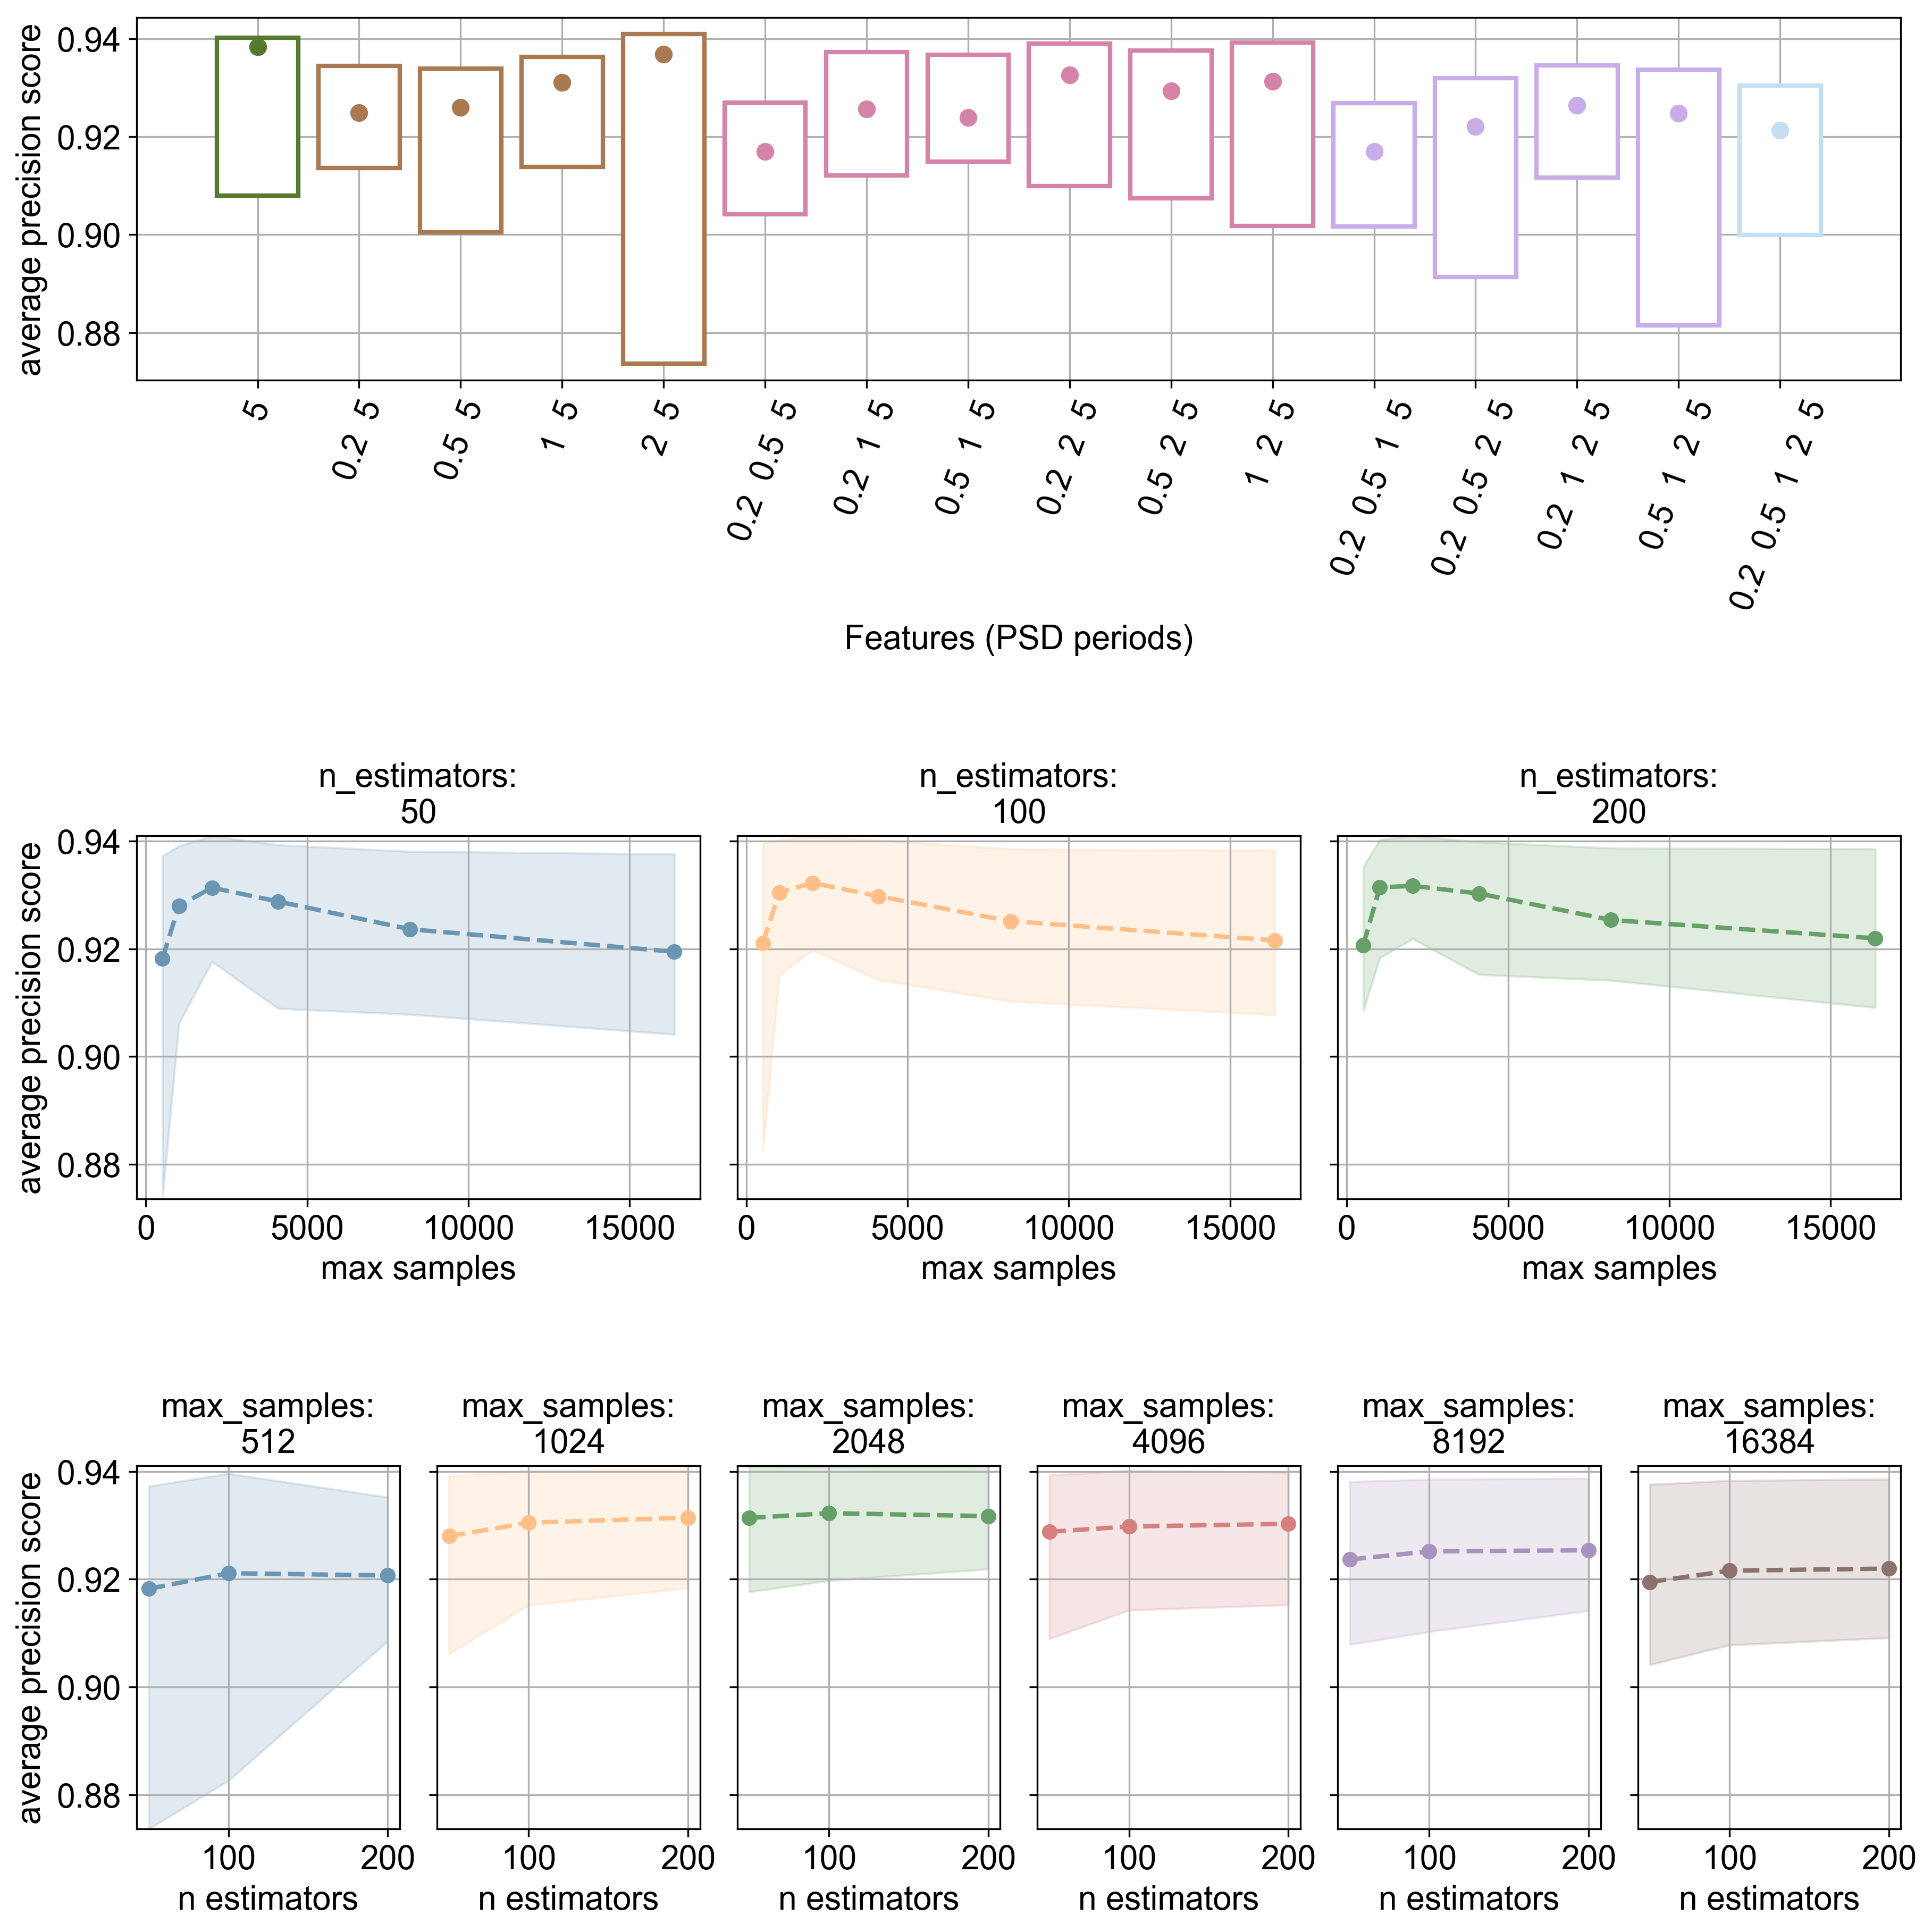

In [6]:
evalinfo(sem_df, 'average_precision_score')

roc_auc_score

Min roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9164  0.9209  0.9269  0.9261  0.9307  0.9302
             100      0.9202  0.9281  0.9319  0.9322  0.9285  0.9324
             200      0.9209  0.9316  0.9325  0.9334  0.9336  0.9339

Median roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9318  0.9413  0.9446  0.9427  0.9407  0.9405
             100      0.9353  0.9432  0.9459  0.9451  0.9426  0.9406
             200      0.9353  0.9433  0.9455  0.9452  0.9430  0.9415

Max roc_auc_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9524  0.9530  0.9524  0.9524  0.9517  0.9512
             100      0.9531  0.9530  0.9530  0.9523  0.9515  0.9516
             200      0.9520  0.9529  0.9531  0.9521  0.9519  0.9515

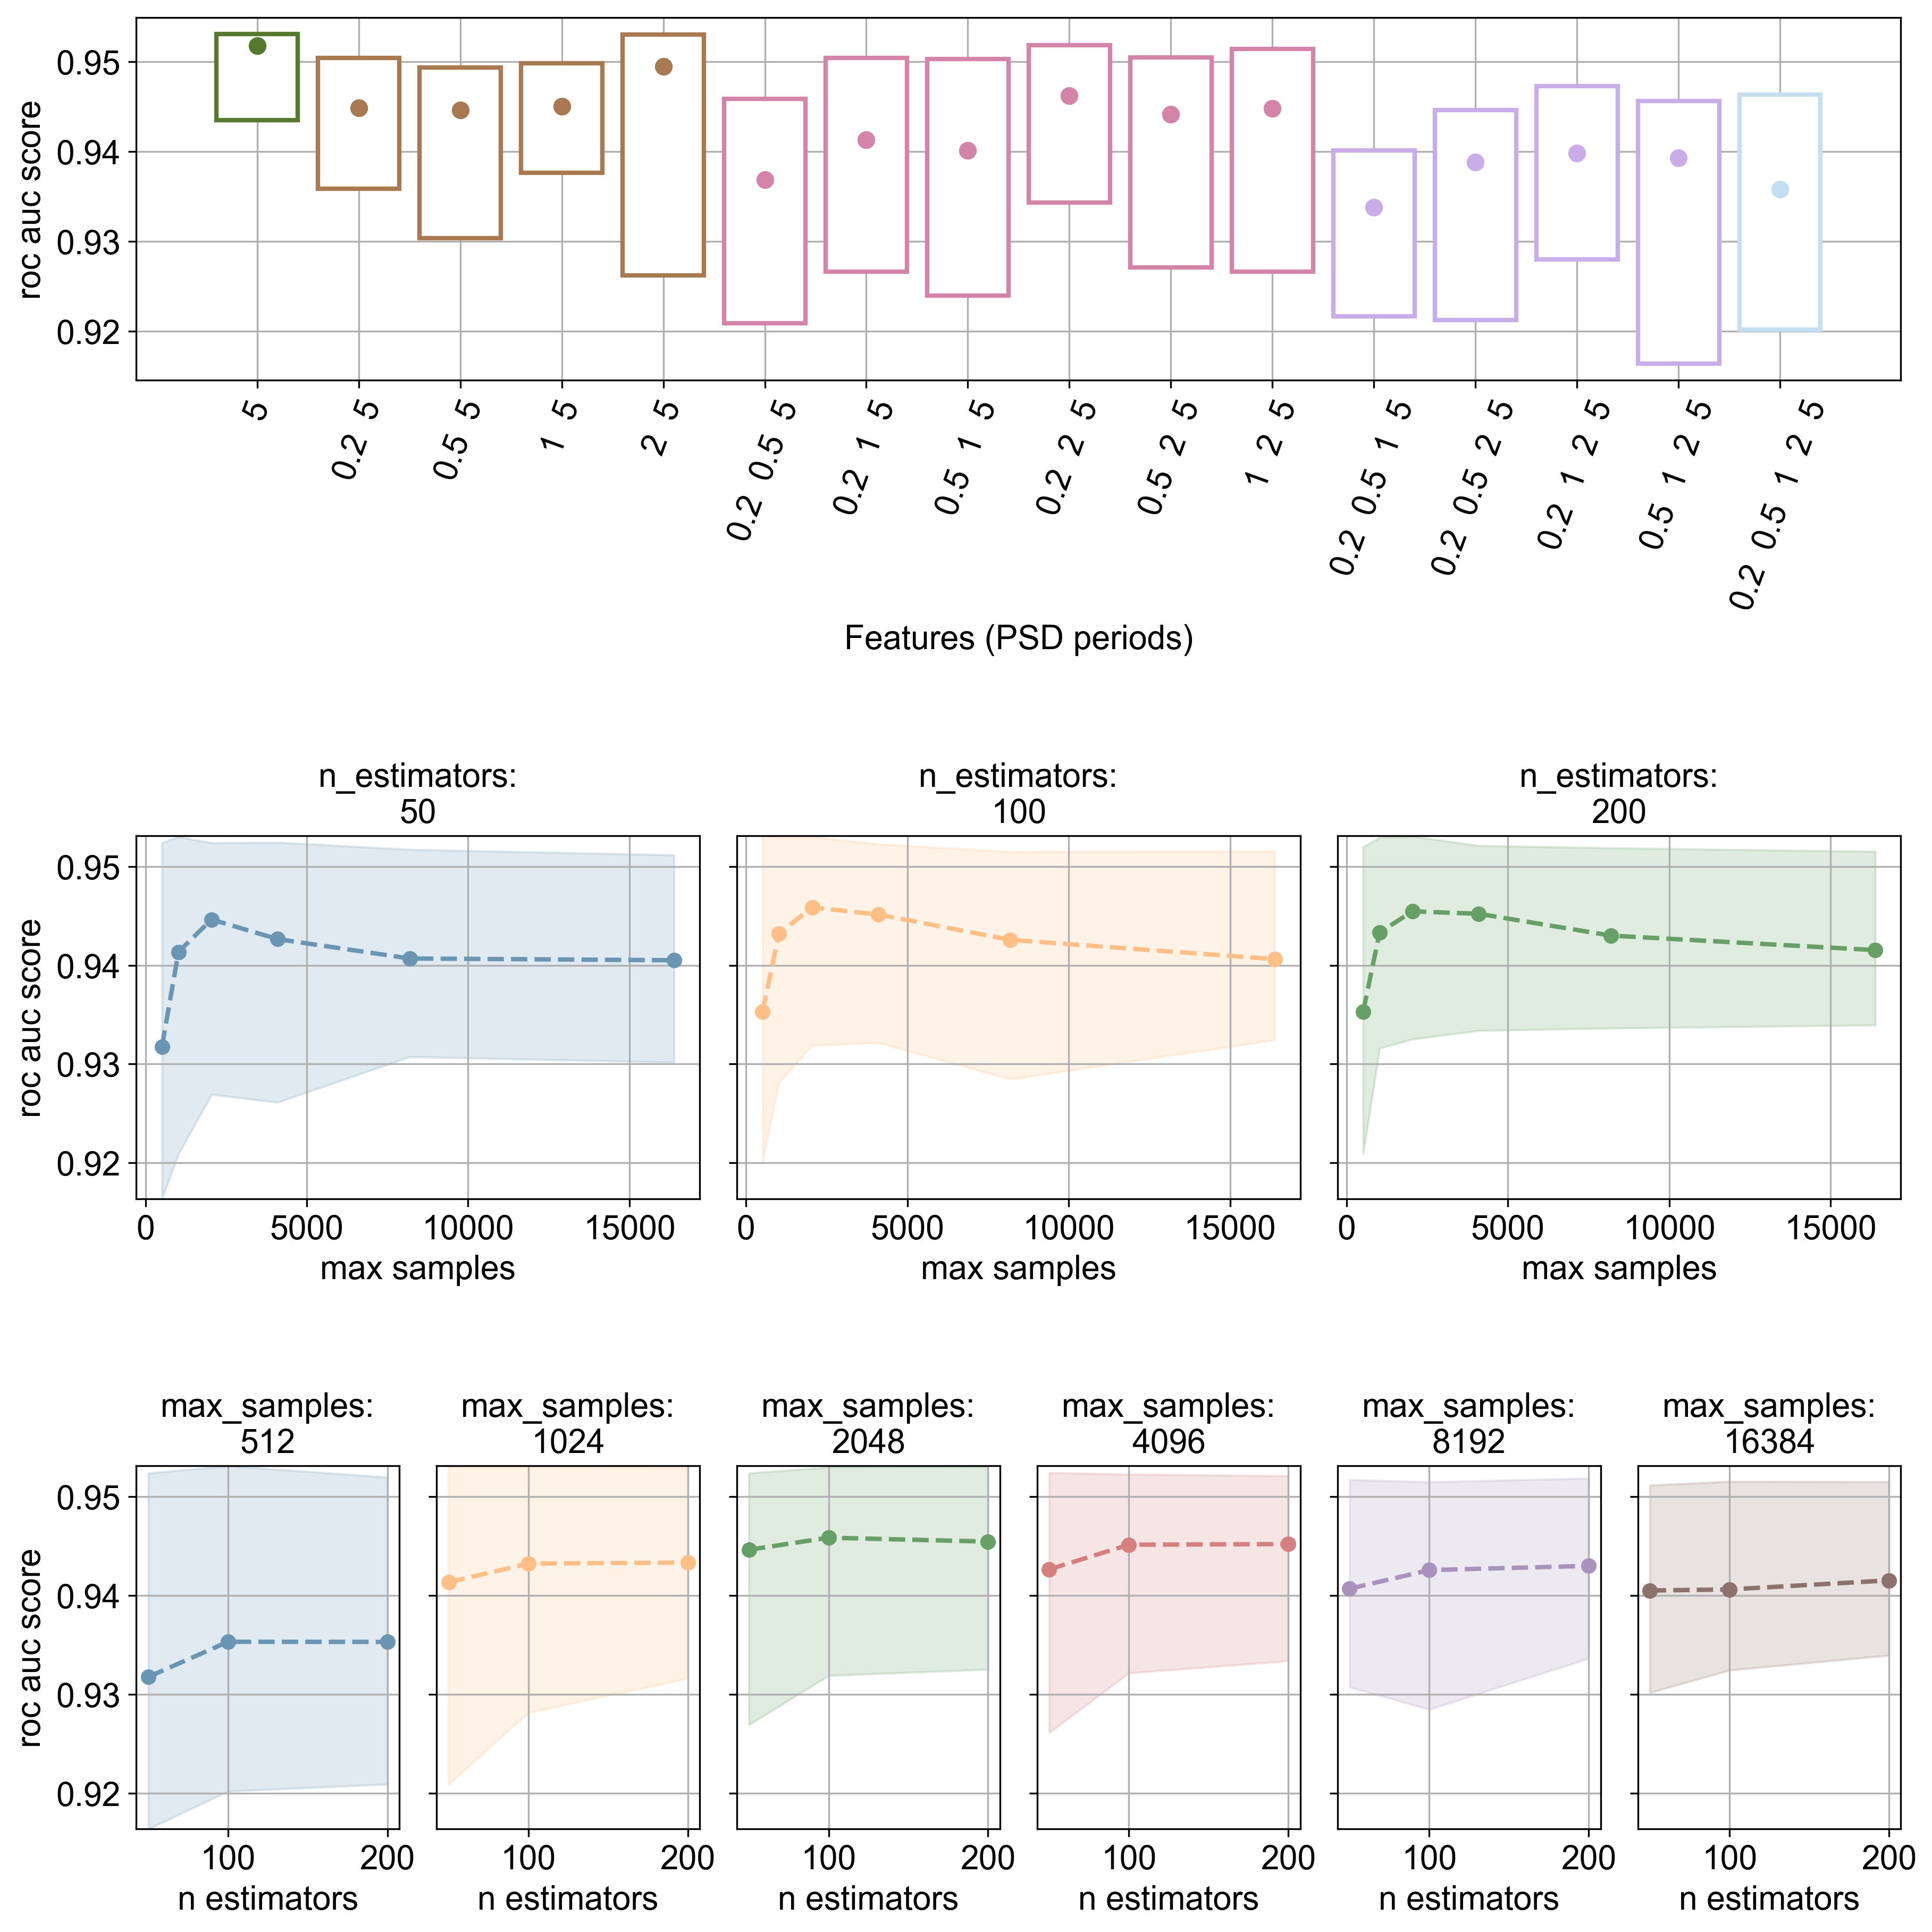

In [7]:
evalinfo(sem_df, 'roc_auc_score')

In [8]:
# We do not show the mean log loss as not informative: the distribution of samples is not symmetric,
# and inliers tend to have scores ~= 0.4 whereas outliers are close to 0.8. A logarithmic measure
# of how points are "close" from 0 and 1, respectively, is affected by this bias

# evalinfo(sem_df, 'log_loss')

In [22]:
printhtml('<h3>Using only evaluations only using the single feature psd@5sec (`sem_df2`)</h3>')
sem_df2 = sem_df[sem_df.feats.isin(['psd@5sec'])]

Using only evaluations only using the single feature psd@5sec (`sem_df2`)

average_precision_score

Min average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9080  0.9369  0.9366  0.9377  0.9368  0.9350
             100      0.9212  0.9382  0.9384  0.9380  0.9375  0.9370
             200      0.9329  0.9392  0.9393  0.9384  0.9385  0.9377

Median average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9336  0.9378  0.9385  0.9383  0.9372  0.9374
             100      0.9256  0.9386  0.9388  0.9386  0.9382  0.9382
             200      0.9345  0.9395  0.9394  0.9386  0.9386  0.9385

Max average_precision_score per hyperparameter (rounded to 4 decimals)

max_samples                                        
                       512     1024    2048    4096    8192    16384
n_estimators 50       0.9373  0.9391  0.9388  0.9387  0.9381  0.9376
             100      0.9396  0.9402  0.9394  0.9389  0.9386  0.9383
             200      0.9352  0.9398  0.9395  0.9388  0.9387  0.9386

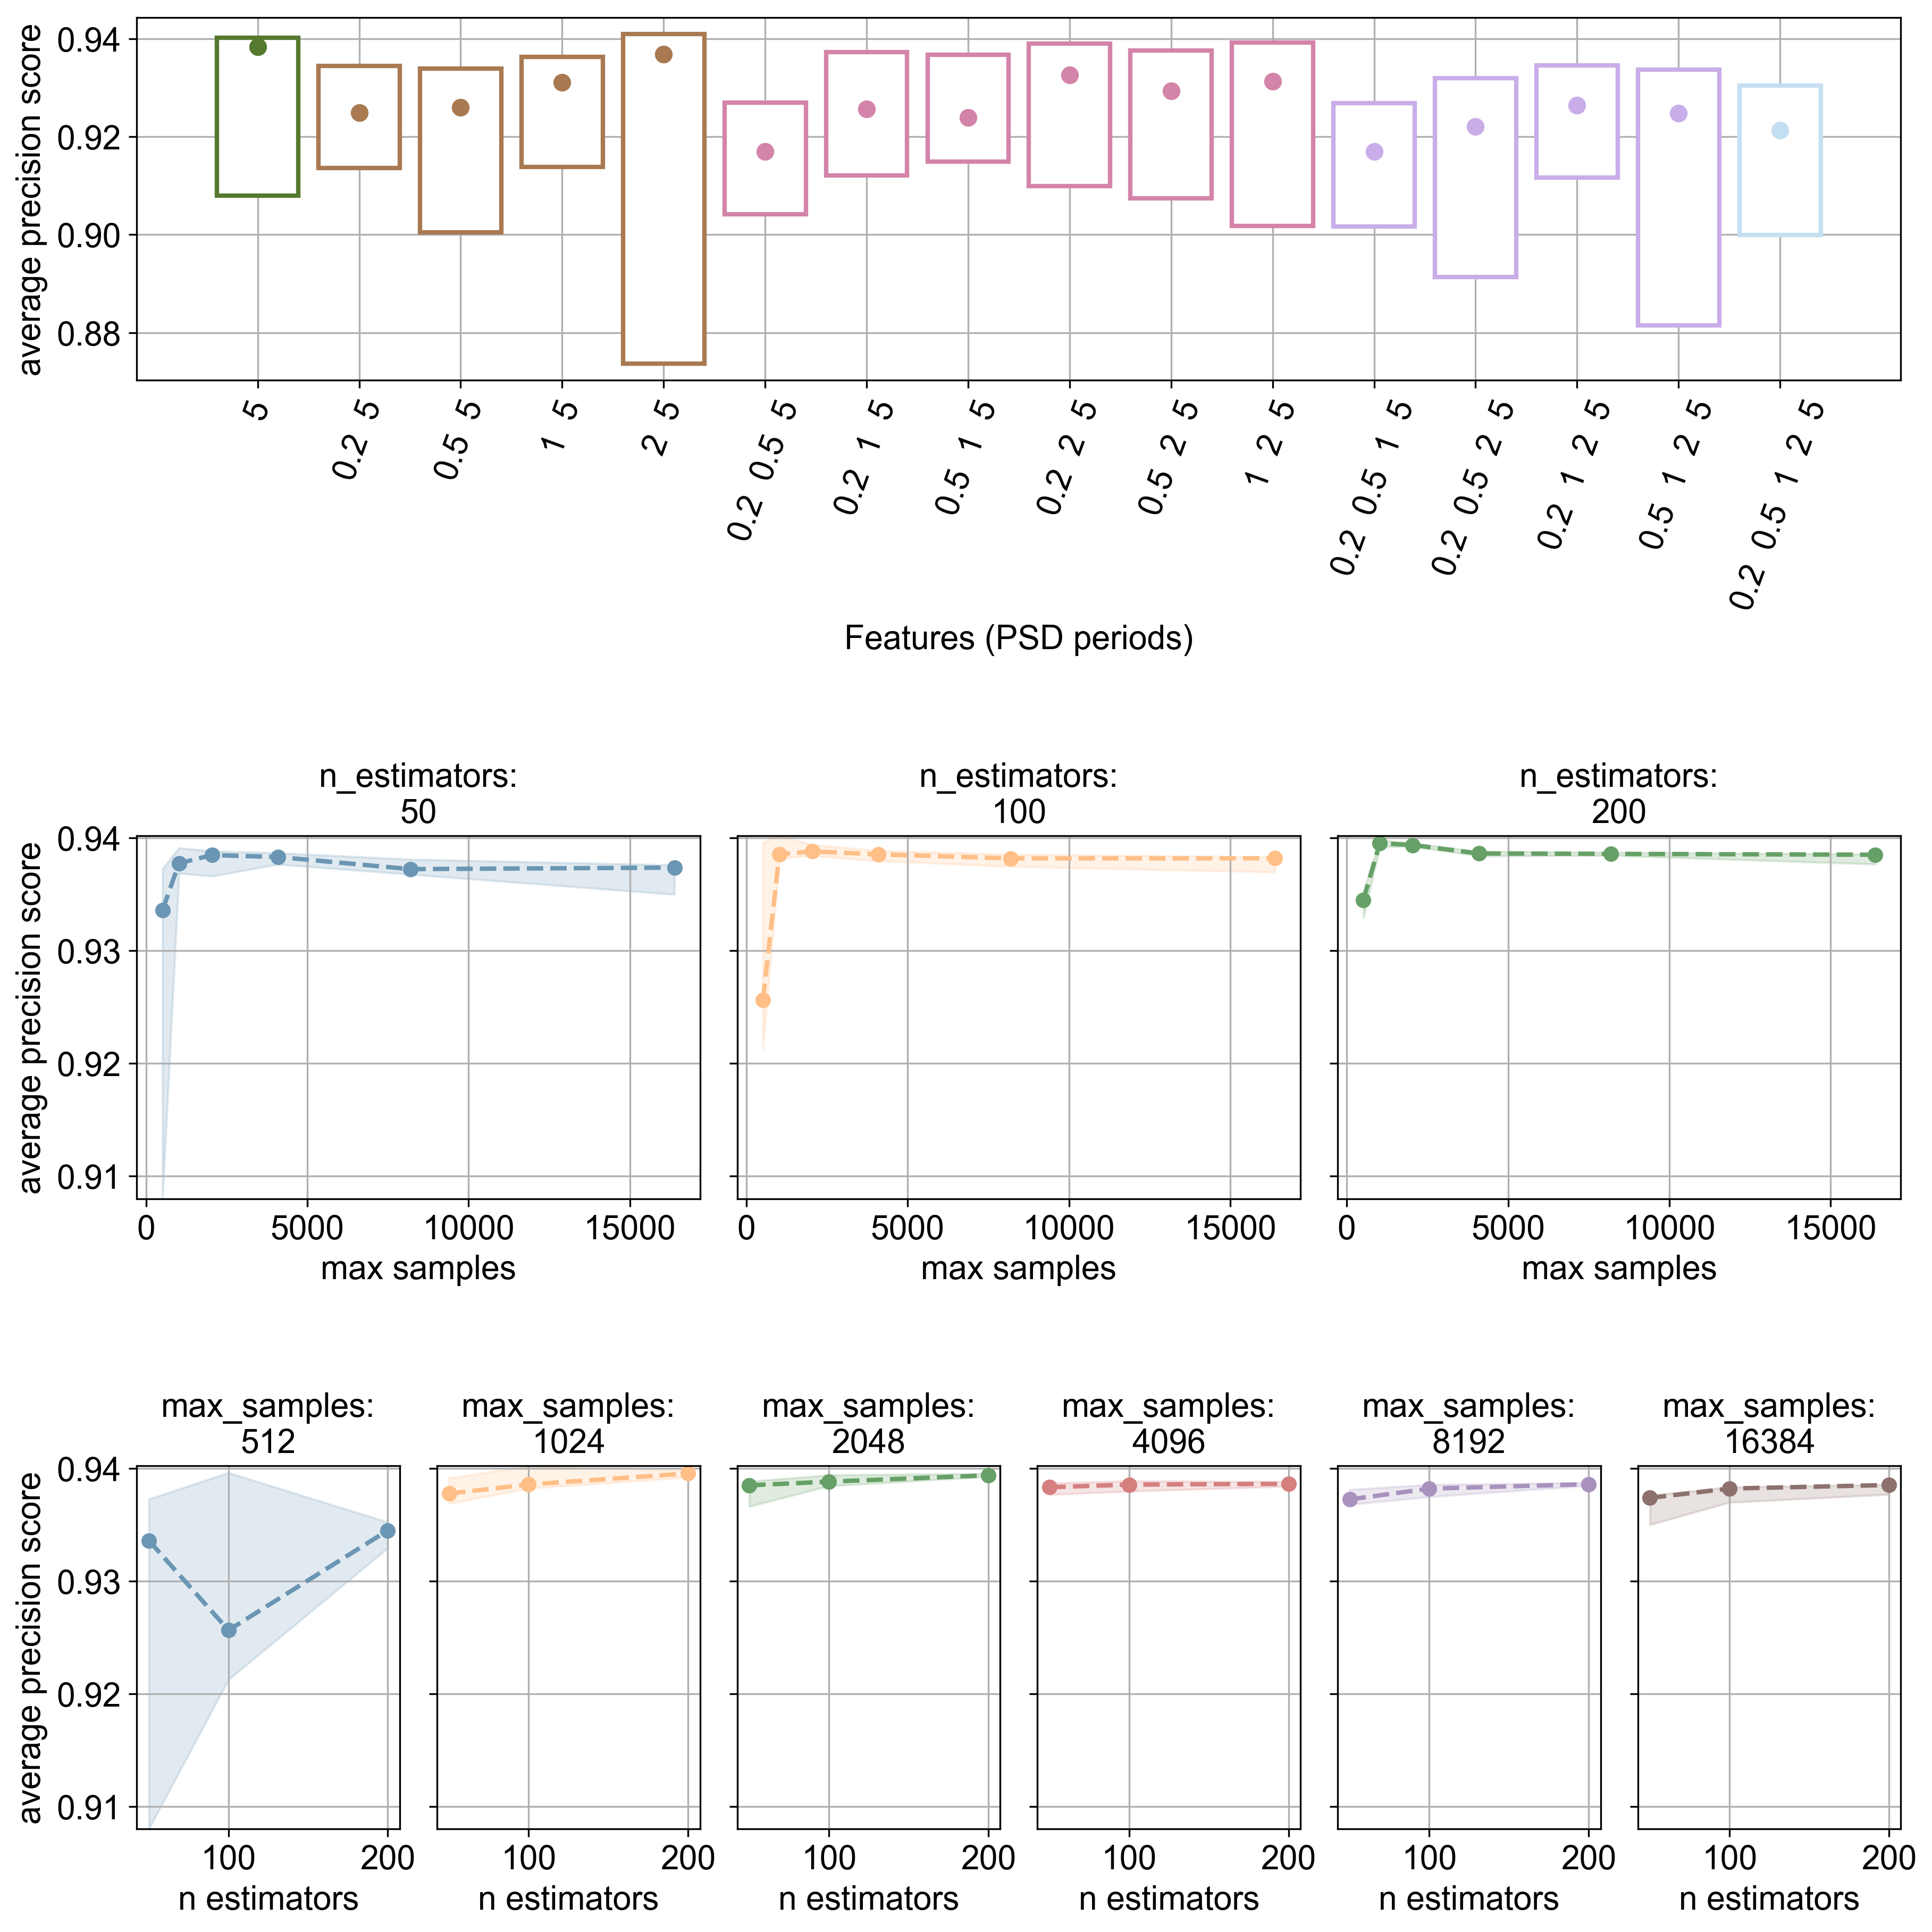

In [24]:
evalinfo(sem_df, 'average_precision_score', sem_df2)

In [ ]:
evalinfo(sem_df2, 'roc_auc_score')

In [ ]:
# see notes above about log loss

# evalinfo(sem_df2, 'log_loss')

In [ ]:
# for the paper: print auc + aps for ALL features, then
# print APS hyperparams for best features only

In [ ]:
# printhtml('<h3>Paper evaluation plot (hyperparameters plot only on features containing "psd@5sec")</h3>')
# evalinfo(sem_df, 'average_precision_score', sem_df_hyperparams = sem_df2)